# Tutorial 05: Homework

### Assignement
  * For the attached data (cleaned data from the 3rd tutorial) try to use linear regression (or ridge regression, if you will) AND decision tree regressor (or boosted tree) applied on features given by PCA.
  * Try to select as less as possible features so that the results are comparably good (in terms of RMSLE) to the results obtained in the 3rd tutorial (RMSLE around 0.12).
  * Experiment with the feature selection:
    * Has removing indicator or discrete features a positive influence?
    * Are the first principal components always the best choice?

In [8]:
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import seaborn as sns
from scipy import stats, optimize
import matplotlib
import matplotlib.pyplot as plt

In [50]:
# loading data
data = pd.read_csv('dataHW05.csv', index_col=0)
dataDropInd = data.copy()
dataDropTen = data.copy()
dataDropInt = data.copy()
for i in dataDropInd.columns:
    if dataDropInd[i].nunique() <= 2:
        dataDropInd = dataDropInd.drop(i, axis=1)
        
        
for i in dataDropTen.columns:
    if dataDropTen[i].nunique() <= 15:
        dataDropTen = dataDropTen.drop(i, axis=1)
        
for i in dataDropInt.columns:
    if dataDropInt[i].dtype == 'int64':
        dataDropInt = dataDropInt.drop(i, axis=1)
        
print(dataDropInd.info())
print(dataDropTen.info())
print(dataDropInt.info())
    
data[data.select_dtypes(['float16', 'float64', 'int64']).columns] = \
data[data.select_dtypes(['float16', 'float64', 'int64']).columns].astype('float64')

# spliting data to train and test datasets
dtrain, dtest = train_test_split(data, test_size=0.25, random_state=42)
X = dtrain.drop(['SalePrice'], axis = 1, errors = 'ignore')
y = dtrain.SalePrice
Xtest = dtest.drop(['SalePrice'], axis = 1, errors = 'ignore')
ytest = dtest.SalePrice

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 0 to 1459
Data columns (total 65 columns):
Id                  1460 non-null int64
MSSubClass          1460 non-null int64
LotFrontage         1460 non-null float64
LotArea             1460 non-null int64
OverallQual         1460 non-null int64
OverallCond         1460 non-null int64
YearBuilt           1460 non-null int64
YearRemodAdd        1460 non-null int64
MasVnrArea          1460 non-null float64
BsmtFinSF1          1460 non-null int64
BsmtFinSF2          1460 non-null int64
BsmtUnfSF           1460 non-null int64
TotalBsmtSF         1460 non-null int64
1stFlrSF            1460 non-null int64
2ndFlrSF            1460 non-null int64
LowQualFinSF        1460 non-null int64
GrLivArea           1460 non-null int64
BsmtFullBath        1460 non-null int64
BsmtHalfBath        1460 non-null int64
FullBath            1460 non-null int64
HalfBath            1460 non-null int64
BedroomAbvGr        1460 non-null int64
KitchenAb

In [3]:
def test(clf, X, y, Xtest, ytest):
    clf.fit(X, y)
    return np.sqrt(mean_squared_error(clf.predict(Xtest), ytest))

In [4]:
print('Root mean squared logarithmic error:', test(LinearRegression(), X, y, Xtest, ytest))

Root mean squared logarithmic error: 0.13215069743365984


In [5]:
print('Root mean squared logarithmic error:', test(DecisionTreeRegressor(), X, y, Xtest, ytest))

Root mean squared logarithmic error: 0.21098401975867542


Minimum linear regresion: 0.13215069743362193
Minimum decision tree: 0.26803726617403384
Minimum linear regresion scaled: 0.1726137613452202
Minimum decision tree scaled: 0.23129470619205444


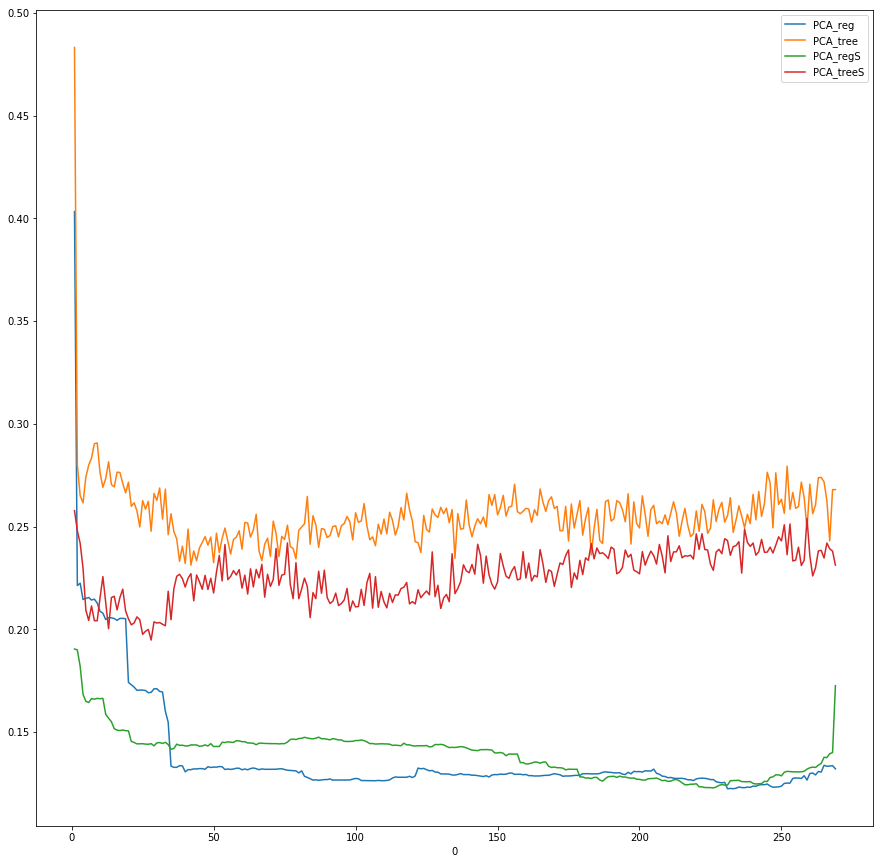

In [21]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
q = 270
data = []

minLinreg = [1, 0]
minTree = [1, 0]
minLinregScale = [1, 0]
minTreeScale = [1, 0]


pca = PCA()
pca.fit(X)
_X = pca.transform(X)
_Xtest = pca.transform(Xtest)

pca.fit(scale(X))
_XS = pca.transform(scale(X))
_XtestS = pca.transform(scale(Xtest))

for i in range(1, q):
    Xsub1 = _X[:,0:i]
    Xsubtest1 = _Xtest[:,0:i]
    
    Xsub2 = _XS[:,0:i]
    Xsubtest2 = _XtestS[:,0:i]
    
    linreg = test(LinearRegression(), Xsub1, y, Xsubtest1, ytest)
    tree = test(DecisionTreeRegressor(), Xsub1, y, Xsubtest1, ytest)
    linregScale = test(LinearRegression(), Xsub2, y, Xsubtest2, ytest)
    treeScale = test(DecisionTreeRegressor(), Xsub2, y, Xsubtest2, ytest)
    
    if linreg < minLinreg[0]: minLinreg = [linreg, i]
    if tree < minTree[0]: minTree = [tree, i]
    if linregScale < minLinregScale[0]: minLinregScale = [linregScale, i]
    if treeScale < minTreeScale[0]: minTreeScale = [treeScale, i]
    data.append([i, linreg, tree, linregScale, treeScale])
    
df = pd.DataFrame(data)
df.set_index(0, inplace=True)
df.columns = ['PCA_reg', 'PCA_tree', 'PCA_regS', 'PCA_treeS']
df.head()
df.plot(figsize=(15, 15))
print("Minimum linear regresion:", minLinreg)
print("Minimum decision tree:", minTree)
print("Minimum linear regresion scaled:", minLinregScale)
print("Minimum decision tree scaled:", minTreeScale)

1. Ostranění indikatoru a diskretnich promenych melo vliv.


2. First principal component nemusí být vždy tím nejlepším výběrem. První komponenta není výbírána na základě dat, ale pouze na základě nejvetšího rozptylu v v daném směru. Tento rozptyl však nemusí být ve vztahu s predikovanou proměnou.